# 🏀 Basketball outcome prediction for matches and outlier players 🏀

In this project, we attempt to:
1. predict the outcome of a match between two basketball teams
2. identify the best players from a dataset of their career stats

A constraining factor with this dataset is that it does not contain individual matches played between teams. In predicting match outcomes between teams, this leaves us with having to look at the averaged team performance relative to another teams aggregate data.


In [83]:
import csv
import numpy as np
import pprint
from sklearn.preprocessing import minmax_scale
import math
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings("ignore")

## 🥇 Team comparison 🥈

We define an index of the statistics and associated columns. We use this for easy access once the data has been loaded from the files

In [84]:

index = {
    "year" : 1, "o_fgm" : 3, "o_fga" : 4, "o_ftm" : 5, "o_fta" : 6, "o_oreb" : 7, "o_dreb" : 8, 
    "o_reb" : 9, "o_asts" : 10, "o_pf" : 11, "o_stl" : 12, "o_to" : 13, "o_blk" : 14, 
    "o_3pm" : 15, "o_3pa" : 16, "o_pts" : 17, "d_fgm" : 18, "d_fga" : 19, "d_ftm" : 20, 
    "d_fta" : 21, "d_oreb" : 22, "d_dreb" : 23, "d_reb" : 24, "d_asts" : 25, "d_pf" : 26, 
    "d_stl" : 27, "d_to" : 28, "d_blk" : 29, "d_3pm" : 30, "d_3pa" : 31, "d_pts" : 32, 
    "pace" : 33, "won" : 34, "lost" : 35
}

filtered_data = {}
team_meta = {}

with open('./data/team_season.txt') as team_data:
    data = csv.reader(team_data)
    data = list(data)
    # Remove the header row
    del data[0]

with open('./data/teams.txt') as team_meta_file:
    team_meta_file = csv.reader(team_meta_file)
    team_meta_file = list(team_meta_file)
    del team_meta_file[0]
    for team_info in team_meta_file:
        team_meta[team_info[0]] = f'{team_info[1]} {team_info[2]}'



The team statistics have been loaded from the datasource. We now process this data into the "4 factors" for each year for each team.

We exclude any seasons from before 1973 due to different statistics collected. It would also be considerably old.

### Linear ranking approach

In [85]:
for team_season in data:
    if (int(team_season[index['year']])<1973):
        continue
    team_array = []
    # Effective filed goal percentage
    team_array.append(round((float(team_season[index['o_fgm']])+0.5*(3*float(team_season[index['o_fgm']])))/float(team_season[index['o_fga']]), 5))
    # Turnover percentage
    posessions = 0.96 * ((float(team_season[index['o_fga']])-float(team_season[index['o_oreb']]))-float(team_season[index['o_to']])+(0.475*float(team_season[index['o_fta']])))
    team_array.append(round(float(team_season[index['o_to']])/posessions, 5))
    # Offensive Rebound Percentage
    if ((float(team_season[index['o_reb']])+float(team_season[index['d_reb']]))!=0):
        team_array.append(round(float(team_season[index['o_reb']])/(float(team_season[index['o_reb']])+float(team_season[index['d_reb']])), 5))
    else:
        continue
    # Free throw rate
    team_array.append(round(float(team_season[index['o_fta']])/float(team_season[index['o_fga']]), 5))
    past_team_data = filtered_data.get(team_season[0])
    if (past_team_data==None):
        past_team_data = []
    past_team_data.append(team_array)
    filtered_data[team_season[0]] = past_team_data


We now filter out any data that is older than 10 years. The remaining data is also aggregated

In [86]:
# While trimming the data and averaging it, also normalize it
team_names_scaled = []
team_stats_scaled = []
scaled_stats = {}

for team, team_stats in filtered_data.items():
    # If more than 10 records, trim them
    team_season_count = min(len(team_stats),10)
    # While trimming we also average them out into one array
    team_stats = (np.array(team_stats)[-10:]).sum(axis=0)/team_season_count
    team_names_scaled.append(team)
    team_stats_scaled.append(team_stats)

team_stats_scaled = minmax_scale(np.array(team_stats_scaled))

# Multiply each of the "4 factors" by the weighting they should have~
for i in range(len(team_stats_scaled)):
    scaled_stats[team_names_scaled[i]] = round(np.sum(np.multiply(team_stats_scaled[i], [0.4, 0.25, 0.2, 0.15])),5)


#### 📝 Teams name are printed below for reference 📝

In [87]:
output = ""
for team in scaled_stats:
    if team_meta.get(team) is not None:
        output += (f'{team}: {team_meta.get(team)}\t')
print(f'Team codes and names: \n{output}')

Team codes and names: 
ATL: Atlanta Hawks	BOS: Boston Celtics	BUF: Buffalo Braves	CAP: Capital Bullets	CAR: Carolina Cougars	CHI: Chicago Bulls	CLE: Cleveland Cavaliers	DEN: Denver Nuggets	DET: Detroit Pistons	GSW: Golden State Warriors	HOU: Houston Rockets	IND: Indiana Pacers	KCK: Kansas City Kings	KEN: Kentucky Colonels	LAL: Los Angeles Lakers	MIL: Milwaukee Bucks	MMT: Memphis Tams	NYK: New York Knicks	NYN: New York Nets	PHI: Philadelphia 76ers	PHO: Phoenix Suns	POR: Portland Trailblazers	SAS: San Antonio Spurs	SDQ: San Diego Conquistadors	SEA: Seattle Supersonics	UTS: Utah Stars	VIR: Virginia Squires	MMS: Memphis Sounds	NOJ: New Orleans Jazz	STL: St. Louis Hawks	WA1: Washington Bullets	SDS: San Diego Sails	NJN: New Jersey Nets	SDC: San Diego Clippers	UTA: Utah Jazz	DAL: Dallas Mavericks	LAC: Los Angeles Clippers	SAC: Sacramento Kings	CHA: Charlotte Hornets	MIA: Miami Heat	MIN: Minnesota Timberwolves	ORL: Orlando Magic	TOR: Toronto Raptors	VAN: Vancouver Grizzlies	WAS: Washington Wiz

#### You can change the team codes below to compare them ✏️

Game prediction between two teams
Team one is Los Angeles Lakers with a four factors score of 0.6915
Team one is San Diego Sails with a four factors score of 0.20451
Los Angeles Lakers has a higher "Four Factors" score from their track record and have an advantage


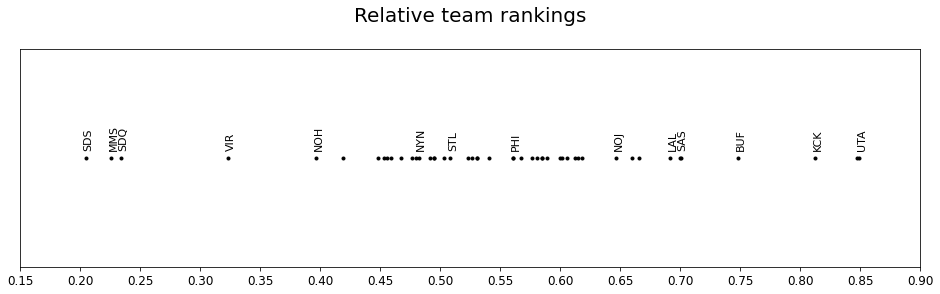

SDS vs UTA: -0.64437
SDQ vs UTA: -0.6153299999999999
NOH vs UTA: -0.45257
STL vs UTA: -0.34056
NOJ vs UTA: -0.20224999999999993
LAL vs UTA: -0.15737999999999996
BUF vs UTA: -0.10100999999999993
VIR vs LAL: -0.36825
LAL vs NYN: 0.20956000000000002
BUF vs STL: 0.23955000000000004
SAS vs LAL: 0.00829000000000002
POR vs PHI: 0.14004000000000005
ORL vs CHR: 0.10423999999999994
MIL vs NYK: 0.05115999999999998
CAP vs CLE: -0.08195000000000002
UTA vs WAS: 0.32255
UTA vs DAL: 0.39303
KCK vs SDS: 0.60766


In [88]:
print("Game prediction between two teams")
# team_one = input("Enter a 3 letter team code from above for team one: ")
# team_two = input("Enter a 3 letter team code from above for team two: ")

team_one = 'LAL'
team_two = 'SDS'

print(f'Team one is {team_meta.get(team_one)} with a four factors score of {scaled_stats[team_one]}')
print(f'Team one is {team_meta.get(team_two)} with a four factors score of {scaled_stats[team_two]}')
if (scaled_stats[team_one]>scaled_stats[team_two]):
    print(f'{team_meta.get(team_one)} has a higher "Four Factors" score from their track record and have an advantage')
else:
    print(f'{team_meta.get(team_two)} has a higher "Four Factors" score from their track record and have an advantage')


teams = scaled_stats.keys()
points_to_label = ['SDS', 'MMS', 'SDQ', 'VIR','NOH','NYN', 'NOJ','LAL','PHI','SAS', 'BUF', 'KCK', 'UTA', 'STL']
plt.yticks([])


for team in teams:
    plt.plot(scaled_stats[team], 0 ,'k.')
    if team in points_to_label:
        plt.text(scaled_stats[team]-0.002, 0.005, team, fontsize=11,rotation=90)
plt.xticks(np.arange(0.15,0.95,0.05),fontsize=12)
fig = plt.gcf()
fig.set_size_inches(20, 4)
plt.title(f'Relative team rankings\n', fontsize=20)
plt.subplots_adjust(right=0.75)  
plt.show()

# Teams can be added below to print the difference in linear performance ratings
compare_teams = [
    ['SDS', 'UTA'],
    ['SDQ', 'UTA'],
    ['NOH', 'UTA'],
    ['STL', 'UTA'],
    ['NOJ', 'UTA'],
    ['LAL', 'UTA'],
    ['BUF', 'UTA'],
    ['VIR', 'LAL'],
    ['LAL', 'NYN'],
    ['BUF', 'STL'],
    ['SAS', 'LAL'],
    ['POR', 'PHI'],
    ['ORL', 'CHR'],
    ['MIL', 'NYK'],
    ['CAP', 'CLE'],
    ['UTA', 'WAS'],
    ['UTA', 'DAL'],
    ['KCK', 'SDS']
]

for pair in compare_teams:
    print(f'{pair[0]} vs {pair[1]}: {scaled_stats[pair[0]]-scaled_stats[pair[1]]}')



#### That is the straightforward linear ranking model complete 

This is a trivial approach in predicting which team is more likely to win, but it does not give us any indication of the margin between the teams. It would be an oversight to conclude that DEN (0.47639) would be defeated by GSW (0.47935). The accuracy of such a classifier is not testable with such a dataset, but it is intuitive to conclude that based off the "Four Factors" being positive attributes, the teams with the highest scores could be expected to perform better than those with the lowest. 

An alternative to improve the binary "win-lose" outcome would be to consider the margin of difference between two scores, but this leaves us with the issue of defining certain outcomes. Should the lowest team have a 100% chance of losing against the highest team? If not, what percent would it be?

## Ensemble learning approach

Another approach altogether could be to use bagging as an ensemble method. We can model several parallel decision trees to each compare a statistic of a tree and then return win, lose, or equal odds within a margin. 

In [89]:
# Process the data again but preserve more columns, unweighted
filtered_data = {}
relevant_stats = ['won', 'lost', 'o_stl', 'o_to', 'o_pts', 'd_pts', 'o_oreb', 'd_oreb', 'o_blk', 'd_blk', 'o_ftm', 'd_ftm']
for team_season in data:
    if (int(team_season[index['year']])<1973):
        continue
    team_array = []
    for stat in relevant_stats:
        team_array.append(float(team_season[index.get(stat)]))
    past_team_data = filtered_data.get(team_season[0])
    if (past_team_data==None):
        past_team_data = []
    past_team_data.append(team_array)
    filtered_data[team_season[0]] = past_team_data

raw_stats = {}
for team, team_stats in filtered_data.items():
    # If more than 10 records, trim them
    team_season_count = min(len(team_stats),10)
    team_stats = (np.array(team_stats)[-10:]).sum(axis=0)/team_season_count
    raw_stats[team] = team_stats


At this stage we have the average stats from each team in their last 10 years. This is not processed into the Four Factors like last time, instead we just retain the atomic data

The ratio weights below could also be adjusted if needed

In [90]:


ratioStats = {
    "Wins": [0, 1],
    "Steals": [2, 3],
    "Points": [4, 5],
    "Rebounds": [6, 7],
    "Blocks": [8, 9],
    "Free throws": [10,11]
}

ratioWeights = {
    "Points": 0.2,
    "Wins": 0.25,
    "Steals": 0.15,
    "Rebounds": 0.10,
    "Free throws": 0.15,
    "Blocks": 0.15
}


#### ⚠️ Change team symbols below to compare them in the decision tree bagging method ⚠️

In [91]:

# NOTE:
# Change team names below to see win probability

# What is the outlook of team 1 playing against team 2?
team_one = "KCK"
team_two = "LAL"

team_one_stats = raw_stats[team_one]
team_two_stats = raw_stats[team_two]

team_one_ratios = {}
team_two_ratios = {}

for statType, stat in ratioStats.items():
    team_one_ratios[statType] = round(team_one_stats[stat[0]]/team_one_stats[stat[1]],6)
    team_two_ratios[statType] = round(team_two_stats[stat[0]]/team_two_stats[stat[1]],6)

# Within what percentage margin should a difference be too close to call? i.e a draw
draw_margin = 0.05
result = {}

for stat in ratioStats:
    margin = team_one_ratios[stat]*draw_margin
    difference = team_one_ratios[stat] - team_two_ratios[stat]
    # Below is effectively our decision tree structure
    if math.fabs(difference)<margin:
        result[stat] = "Uncertain"
    else:
        if difference<0:
            result[stat] = "Lose"
        else:
            result[stat] = "Win"

pprint.pprint(result)

estimate = {
    "Win":0,
    "Uncertain":0,
    "Lose":0
}

for resultItem, outcome in result.items():
    estimate[outcome] = round(estimate.get(outcome)+ratioWeights.get(resultItem),2)

print("Team 1 has the estimated outlooks against team 2:")
pprint.pprint(estimate)

{'Blocks': 'Lose',
 'Free throws': 'Lose',
 'Points': 'Uncertain',
 'Rebounds': 'Uncertain',
 'Steals': 'Lose',
 'Wins': 'Lose'}
Team 1 has the estimated outlooks against team 2:
{'Lose': 0.7, 'Uncertain': 0.3, 'Win': 0}


## ⛹️‍♂️ Player outlier detection ⛹️‍♂️


In [92]:
player_index = {"id":0, "year":1, "firstname":2, "lastname":3, "team":4, "leag":5, "gp":6, "minutes":7,
    "pts":8, "oreb":9, "dreb":10, "reb":11, "asts":12, "stl":13, "blk":14, "to":15, "pf":16, "fga":17,
    "fgm":18, "fta":19, "ftm":20, "tpa":21, "tpm":22
}

player_id_to_name = {}

with open('./data/player_regular_season.txt') as player_data:
    data = csv.reader(player_data)
    data = list(data)
    # Remove the header row
    del data[0]

player_data = {}
for player_season in data:
    if int(player_season[player_index.get("year")]) < 1973:
        continue

    existing_player_season = np.zeros(15, dtype=int)
    if player_data.get(player_season[player_index.get("id")]) is not None:
        existing_player_season = player_data.get(player_season[player_index.get("id")])
    single_player_season = np.array([
        int(player_season[player_index.get("pts")]),
        int(player_season[player_index.get("reb")]),
        int(player_season[player_index.get("asts")]),
        int(player_season[player_index.get("stl")]),
        int(player_season[player_index.get("blk")]),
        int(player_season[player_index.get("fgm")]),
        int(player_season[player_index.get("ftm")]),
        int(player_season[player_index.get("to")]),
        int(player_season[player_index.get("oreb")]),
        int(player_season[player_index.get("dreb")]),
        int(player_season[player_index.get("pf")]),
        int(player_season[player_index.get("minutes")]),
        (int(player_season[player_index.get("fta")])-int(player_season[player_index.get("ftm")])),
        (int(player_season[player_index.get("fga")])-int(player_season[player_index.get("fgm")])),
        int(player_season[player_index.get("gp")])
        ])
    player_id_to_name[player_season[player_index.get("id")]] = player_season[player_index.get("firstname")]+ " "+player_season[player_index.get("lastname")]
    existing_player_season = np.add(existing_player_season, single_player_season)
    player_data[player_season[player_index.get("id")]] = existing_player_season

less_than_60_min = []
for playerId, accumulative_player_data in player_data.items():
    if accumulative_player_data[11] < 60:
        less_than_60_min.append(playerId)
for playerId in less_than_60_min:
    player_data.pop(playerId)



At this stage, the player data has been parsed and filtered. The credits and AV calculation comes next.

In [93]:
player_av = {}
for playerName, stats in player_data.items():
    credits = stats[0] + stats[1] + stats[2] + stats[3] + stats[4] - stats[5] - stats[6] - stats[7]
    av = (credits**(3/4))/21
    player_av[playerName] = round(av,3)



### DBSCAN approach
Calculating of the Player Efficiency Rating (PER) follows. There 3PTM (3 pointers made) statistic is not present in the dataset, as such the PTS (points) stat is substituted. Below uses the simplified PER method.

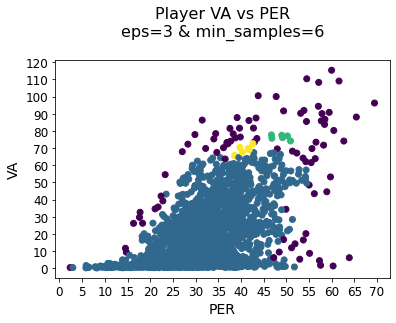

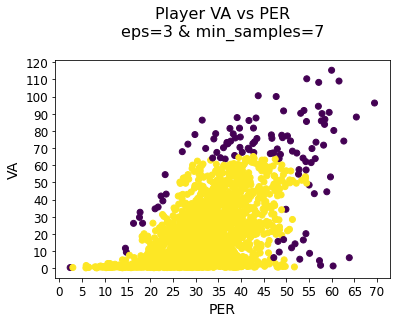

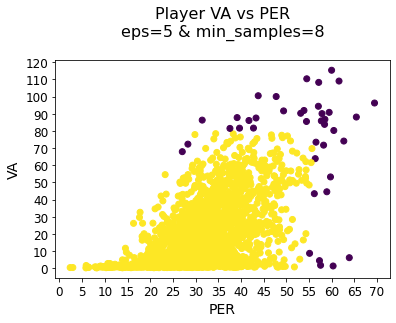

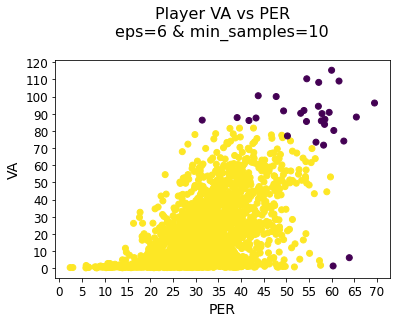

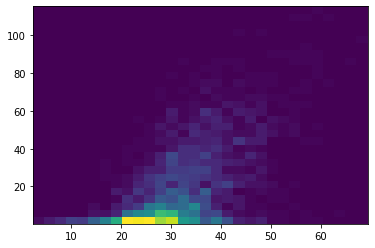

In [94]:
player_per = {}
for playerName, stats in player_data.items():
    # FGM + Steals + Points + FTM
    per = (stats[5]*85.91) + (stats[3]*53.897) + (stats[0]*51.757) + (stats[6]*46.845)
    # Blocks + Off reb + Def reb + Assists 
    per += (stats[4]*39.19) + (stats[8]*39.19) + (stats[9]*14.707) + (stats[2]*34.677)
    # Foulfs - ft missed - fg missed - turnover 
    per += (stats[10]*-17.174) + (stats[12]*-20.091) + (stats[13]*-39.190) + (stats[7]*-53.897) 
    per = (per/stats[11])
    player_per[playerName] = round(per,3)

x = []
y = []
names = []
# Python dictionaries are not reliably iterated in order, we need to workaround this
for player, per in player_per.items():
    x.append(per)
    y.append(player_av.get(player))
    names.append(player)

eps = [3, 3, 5, 6]
samples = [6, 7, 8, 10]

for i in range(0,len(eps)):
    plt.rcParams["figure.figsize"] = (6,4)
    two_d = np.vstack((x, y)).T
    model = DBSCAN(eps=eps[i], min_samples=samples[i], n_jobs=-1).fit(two_d)
    colors = model.labels_
    plt.scatter(x, y, c=colors)
    plt.yticks(ticks=np.arange(0,121,step=10,dtype=int),fontsize=12)
    plt.xticks(ticks=np.arange(0,75,step=5,dtype=int),fontsize=12)
    plt.xlabel('PER', fontsize=14)
    plt.ylabel('VA', fontsize=14)
    plt.title(f'Player VA vs PER\neps={eps[i]} & min_samples={samples[i]}\n', fontsize=16)
    plt.show()

# Set below to true to print outliers
print_outliers = False
if print_outliers:
    print("Outliers:")
    outlier_count = 0
    for labelIndex in range(0, len(model.labels_)):
        if model.labels_[labelIndex]==-1:
            outlier_count+=1
            print(player_id_to_name.get(names[labelIndex]))
    print(f'Count: {outlier_count}')
  
# Below is just a heatmap for the distribution  
plt.hist2d(x,y,bins=(30,30))
plt.show()


### Moving curve approach

Default strictness is 6. It can technically be any int value.

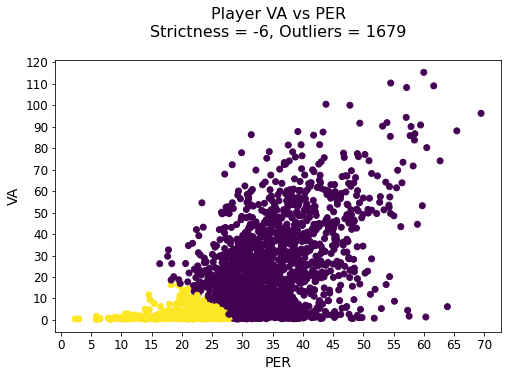

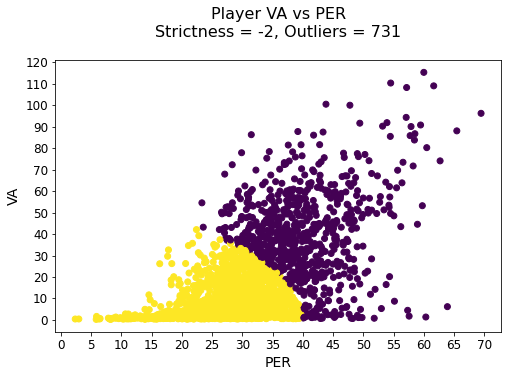

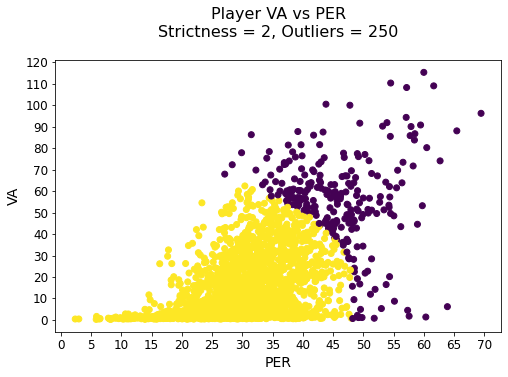

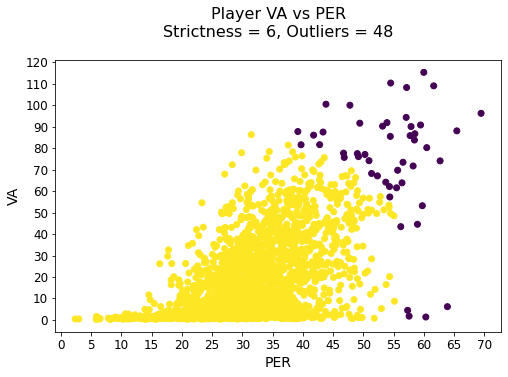

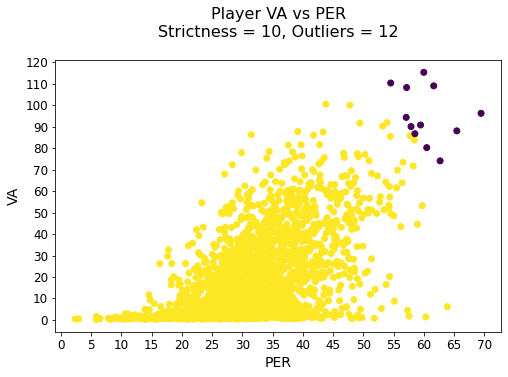

In [95]:


for i in range(-6,13,4):
    strictness = i
    colors = []
    x_adjustment = 16-(2*strictness)
    y_adjustment = 10+(5*strictness)

    for i in range(0, len(x)):
        if ((x[i]+x_adjustment)**2)+((y[i]-y_adjustment)**2)>3600:
            if (x[i]<(60-x_adjustment))and(y[i]<y_adjustment):
                colors.append(1)
            else:
                colors.append(-1)
        else:
            colors.append(1)

    plt.rcParams["figure.figsize"] = (8,5)
    plt.scatter(x, y, c=colors)
    plt.yticks(ticks=np.arange(0,121,step=10,dtype=int),fontsize=12)
    plt.xticks(ticks=np.arange(0,75,step=5,dtype=int),fontsize=12)
    plt.xlabel('PER', fontsize=14)
    plt.ylabel('VA', fontsize=14)
    colors = np.array(colors)
    plt.title(f'Player VA vs PER\nStrictness = {strictness}, Outliers = {len(np.where(colors==-1)[0])}\n', fontsize=16)

    plt.show()